In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/content/SAMSUNG.csv')
df_reversed = df.loc[::-1].reset_index(drop=True)
df1=df.reset_index()['Close']
features = df_reversed[['Open', 'High', 'Low', 'Close']].values

In [3]:
df_reversed

,Date,Close,Open,High,Low
0,5/27/2024,77200,75300,78100,74000
1,5/24/2024,75900,76800,77000,75800
2,5/23/2024,78300,77700,79100,77100
3,5/22/2024,77700,78100,78700,77300
4,5/21/2024,78400,78500,79000,78200
...,...,...,...,...,...
1542,3/8/2019,43800,44450,44800,43800
1543,3/7/2019,44450,43400,44950,43400
1544,3/6/2019,44000,44000,44300,43700
1545,3/5/2019,44250,44600,45100,44150


In [4]:
df1

0       44850
1       44250
2       44000
3       44450
4       43800
        ...  
1542    78400
1543    77700
1544    78300
1545    75900
1546    77200
Name: Close, Length: 1547, dtype: int64

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# Xây dựng mô hình RNN
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))


In [11]:
# Biên dịch mô hình
rnn_model.compile(optimizer='adam', loss='mse')

In [12]:
# Huấn luyện mô hình RNN
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
29/29 [==============================] - 10s 119ms/step - loss: 0.0527 - val_loss: 8.5319e-04
Epoch 2/10
29/29 [==============================] - 2s 84ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 3/10
29/29 [==============================] - 3s 89ms/step - loss: 0.0016 - val_loss: 7.4151e-04
Epoch 4/10
29/29 [==============================] - 4s 138ms/step - loss: 0.0013 - val_loss: 7.2267e-04
Epoch 5/10
29/29 [==============================] - 3s 99ms/step - loss: 0.0013 - val_loss: 6.8320e-04
Epoch 6/10
29/29 [==============================] - 2s 78ms/step - loss: 0.0012 - val_loss: 6.4083e-04
Epoch 7/10
29/29 [==============================] - 2s 70ms/step - loss: 0.0011 - val_loss: 5.8237e-04
Epoch 8/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0011 - val_loss: 5.9215e-04
Epoch 9/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0011 - val_loss: 5.2139e-04
Epoch 10/10
29/29 [==============================] - 1s 42ms/step - loss: 

In [13]:
# Trích xuất các đặc trưng từ tầng cuối cùng của RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

7/7 [==============================] - 0s 13ms/step


In [14]:
# Kết hợp các đặc trưng từ RNN với các đặc trưng khác (ở đây chỉ dùng các đặc trưng từ RNN)
X_train_combined = train_features_rnn
X_test_combined = test_features_rnn


In [15]:
# Tạo dataset cho LightGBM
train_data = lgb.Dataset(X_train_combined, label=y_train)
test_data = lgb.Dataset(X_test_combined, label=ytest, reference=train_data)


In [16]:
# Thiết lập các tham số cho LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [17]:
# Huấn luyện mô hình LightGBM với early stopping
evals_result = {}
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]
)

# Dự đoán và đánh giá
y_pred = lgb_model.predict(X_test_combined, num_iteration=lgb_model.best_iteration)
mse = mean_squared_error(ytest, y_pred)
print(f'Mean Squared Error: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1136, number of used features: 1
[LightGBM] [Info] Start training from score 0.462029
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[94]	train's rmse: 0.0279359	valid's rmse: 0.0349164
Mean Squared Error: 0.0012191581406383184


In [18]:
# 10. Hàm dự đoán 30 ngày tiếp theo
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []
    current_sequence = initial_data[-time_step:]  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(30):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence[1:], next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 30 ngày tiếp theo
initial_data = features[-time_step:].reshape(-1, 1)

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 [==============================] - 0s 23ms/step
Dự đoán giá đóng cửa cho 30 ngày tiếp theo: [0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.8334850467900006, 0.7895361103547616, 0.760408931487658, 0.7358151559671501]


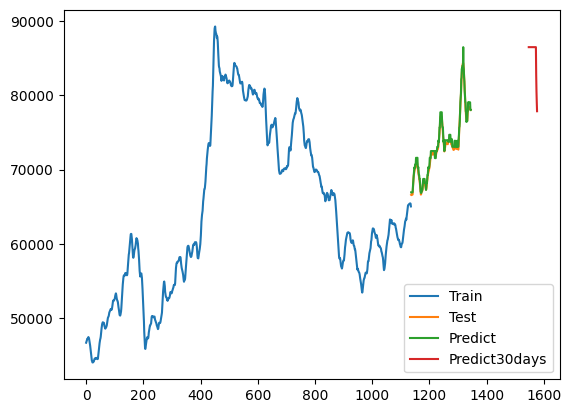

In [19]:
import matplotlib.pyplot as plt

# 14. Vẽ hình

# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()




# Dự báo 60 ngày tiếp theo

In [20]:
def predict_next_days(rnn_model, lgb_model, initial_data, time_step=100, days_to_predict=60):
    predictions = []
    current_sequence = initial_data[-time_step:]  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(days_to_predict):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence[1:], next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 60 ngày tiếp theo
initial_data = features[-time_step:].reshape(-1, 1)

# Dự đoán 60 ngày tiếp theo
days_to_predict = 60
next_60_days_predictions = predict_next_days(rnn_model, lgb_model, initial_data, time_step, days_to_predict)
print("Dự đoán giá đóng cửa cho 60 ngày tiếp theo:", next_60_days_predictions)



1/1 [==============================] - 0s 25ms/step
Dự đoán giá đóng cửa cho 60 ngày tiếp theo: [0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.8334850467900006, 0.7895361103547616, 0.760408931487658, 0.7358151559671501, 0.7087653040873609, 0.6917986817885687, 0.6722277689273779, 0.6530660021019434, 0.6575750218376859, 0.6398108818390361, 0.6398108818390361, 0.6282900285596646, 0.6282900285596646, 0.6091435443099305, 0.6095914018754801, 0.6095914018754801, 0.6095914018754801, 0.6095914018754801, 0.6100891365028642, 0.61

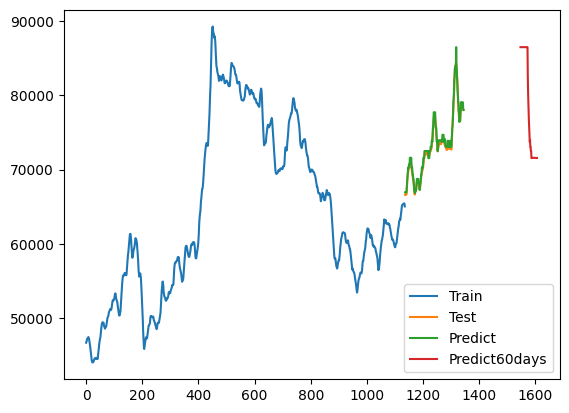

In [21]:
import matplotlib.pyplot as plt

# Chuyển đổi lại train_data và test_data từ LightGBM Dataset sang mảng numpy
train_data_array = train_features_rnn
test_data_array = test_features_rnn

# Vẽ đồ thị
train_data_index = pd.RangeIndex(start=0, stop=len(train_data_array), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data_array), label='Train')

test_data_index = pd.RangeIndex(start=len(train_data_array), stop=len(train_data_array) + len(test_data_array), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data_array), label='Test')

# Điều chỉnh y_pred để có đúng hình dạng và chiều dài
test_data_index_pred = pd.RangeIndex(start=len(train_data_array), stop=len(train_data_array) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Điều chỉnh next_60_days_predictions để có đúng hình dạng và chiều dài
predict_data_index = pd.RangeIndex(start=len(df_reversed), stop=len(df_reversed) + len(next_60_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1)), label='Predict60days')

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()



In [22]:
def predict_next_days(rnn_model, lgb_model, initial_data, time_step=100, days_to_predict=90):
    predictions = []
    current_sequence = initial_data[-time_step:]  # Lấy chuỗi dữ liệu cuối cùng làm dữ liệu khởi đầu

    for _ in range(days_to_predict):
        # Reshape data for prediction
        current_sequence_reshaped = np.expand_dims(current_sequence, axis=0)

        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence_reshaped)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        next_day = np.array([[next_close[0]]])
        current_sequence = np.vstack((current_sequence[1:], next_day))

    return predictions

# Chuẩn bị dữ liệu ban đầu cho dự đoán 90 ngày tiếp theo
initial_data = features[-time_step:].reshape(-1, 1)

# Dự đoán 90 ngày tiếp theo
days_to_predict = 90
next_90_days_predictions = predict_next_days(rnn_model, lgb_model, initial_data, time_step, days_to_predict)
print("Dự đoán giá đóng cửa cho 90 ngày tiếp theo:", next_90_days_predictions)



1/1 [==============================] - 0s 23ms/step
Dự đoán giá đóng cửa cho 90 ngày tiếp theo: [0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.9088940358466518, 0.8334850467900006, 0.7895361103547616, 0.760408931487658, 0.7358151559671501, 0.7087653040873609, 0.6917986817885687, 0.6722277689273779, 0.6530660021019434, 0.6575750218376859, 0.6398108818390361, 0.6398108818390361, 0.6282900285596646, 0.6282900285596646, 0.6091435443099305, 0.6095914018754801, 0.6095914018754801, 0.6095914018754801, 0.6095914018754801, 0.6100891365028642, 0.61

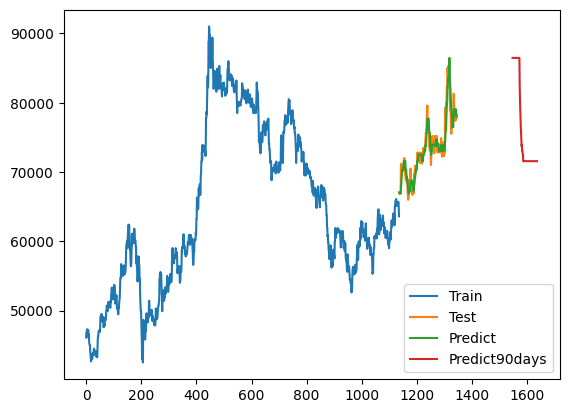

In [23]:
import matplotlib.pyplot as plt

# Chuyển đổi lại train_data và test_data từ LightGBM Dataset sang mảng numpy
train_data_array = X_train[:, -1].reshape(-1, 1)
test_data_array = X_test[:, -1].reshape(-1, 1)

# Vẽ đồ thị
train_data_index = pd.RangeIndex(start=0, stop=len(train_data_array), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data_array), label='Train')

test_data_index = pd.RangeIndex(start=len(train_data_array), stop=len(train_data_array) + len(test_data_array), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data_array), label='Test')

# Điều chỉnh y_pred để có đúng hình dạng và chiều dài
test_data_index_pred = pd.RangeIndex(start=len(train_data_array), stop=len(train_data_array) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Điều chỉnh next_90_days_predictions để có đúng hình dạng và chiều dài
predict_data_index = pd.RangeIndex(start=len(df_reversed), stop=len(df_reversed) + len(next_90_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1)), label='Predict90days')

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()
